In [1667]:
# import Python library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
import collections

# Data source: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating/versions/400?resource=download
data = pd.read_csv('World-Stock-Prices-Dataset.csv', encoding='utf-8')

In [1668]:
# Here we only consider the stock prices in 2024. Select the data and sort them accordingly:
data["Date"] = pd.to_datetime(data["Date"], utc = True)
data_2024 = data[data['Date'].dt.year == 2024]
data_2024 = data_2024.sort_values('Date').reset_index(drop=True)

In [1670]:
# Data cleanness, part 1: select all the data value which is NaN and Empty. 
summary = pd.DataFrame({
    "NaN_count": data_2024.isna().sum(),
    "Empty_count": (data_2024.eq("")).sum()
})
# Summarize the row of 2024-year stock price, give the value which is NaN or Empty as well as the ticker.
print("# Rows: " + str(len(data_2024['Date'])))
print(summary)

# Rows: 17248
               NaN_count  Empty_count
Date                   0            0
Open                   0            0
High                   0            0
Low                    0            0
Close                  0            0
Volume                 0            0
Brand_Name             0            0
Ticker                 0            0
Industry_Tag           0            0
Country                0            0
Dividends              0            0
Stock Splits           0            0
Capital Gains      17246            0


In [1673]:
# Print out the two stocks whose capital gains is not NaN, they are both 0.0.
data_2024[pd.notna(data_2024["Capital Gains"])]

,Date,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains
8645,2024-07-17 04:00:00+00:00,47.375,47.375,47.375,47.375,0.0,puma,PMMAF,apparel,germany,0.0,0.0,0.0
8677,2024-07-18 04:00:00+00:00,47.375,47.375,47.375,47.375,0.0,puma,PMMAF,apparel,germany,0.0,0.0,0.0


In [1675]:
# Data cleanness, part 2: stock types analysis
stock_types = list(set(data_2024["Ticker"].tolist()))
print("There are " + str(len(stock_types)) + " types of stocks in 2024: ")
print(stock_types)

There are 61 types of stocks in 2024: 
['GOOGL', 'FDX', 'TM', 'MMM', 'SPOT', 'HMC', 'V', 'CRM', 'ZI', 'ABNB', 'CMG', 'CL', 'UBSFY', 'MAR', 'SBUX', 'HLT', 'UL', 'HD', 'MSFT', 'MCD', 'AEO', 'COST', 'COIN', 'LVMUY', 'UBER', 'NVDA', 'JPM', 'LUV', 'PTON', 'MA', 'NFLX', 'LOGI', 'RBLX', 'AMD', 'ADBE', 'NKE', 'PG', 'ZM', 'BAMXF', 'PMMAF', 'JNJ', 'ADDYY', 'JWN', 'TGT', 'DIS', 'FL', 'SHOP', 'TSLA', 'PHG', 'PINS', 'KO', 'SQ', 'CROX', 'AXP', 'CSCO', 'HSY', 'DAL', 'AMZN', 'NTDOY', 'POAHY', 'AAPL']


In [1677]:
# The stock 'CMG' has abnormal jumping from 3000+ down to 70- in June.
print(data_2024[(data_2024['Ticker'] == 'CMG') & (data_2024['Date'].dt.month == 6) & (data_2024['Date'].dt.day > 15)])

# Out of technical reason, we remove it from out stock_types.
stock_types.remove('CMG')

                          Date         Open         High          Low  \
7076 2024-06-17 04:00:00+00:00  3326.620117  3384.040039  3295.000000   
7139 2024-06-18 04:00:00+00:00  3435.000000  3463.070068  3370.000000   
7231 2024-06-20 04:00:00+00:00  3445.580078  3445.580078  3188.000000   
7353 2024-06-21 04:00:00+00:00  3225.199951  3233.340088  3193.209961   
7369 2024-06-21 04:00:00+00:00  3225.199951  3231.580078  3193.205078   
7436 2024-06-24 04:00:00+00:00    64.294998    64.459999    63.284199   
7493 2024-06-25 04:00:00+00:00    64.325996    65.795403    64.279999   
7504 2024-06-26 04:00:00+00:00    65.809998    66.309998    62.750000   
7605 2024-06-27 04:00:00+00:00    65.879997    65.889999    61.840000   
7630 2024-06-28 04:00:00+00:00    62.029999    63.770000    61.570000   
7696 2024-06-28 04:00:00+00:00    62.029999    63.769699    61.570000   

            Close      Volume Brand_Name Ticker Industry_Tag Country  \
7076  3365.459961    422400.0   chipotle    CMG    

In [1679]:
# Data cleanness, part 3: execution dates analysis. First we observe an example ticker of 'GOOGL':
example_ticker = 'GOOGL'
example_stock_price = data_2024[data_2024['Ticker'] == example_ticker].sort_values("Date").reset_index(drop=True)
execution_date = example_stock_price['Date']
print("There are "+ str(len(execution_date)) + " execution dates in 2024, but " 
      + str(len(execution_date) - len(set(execution_date))) + " of them are duplicated")

There are 283 execution dates in 2024, but 31 of them are duplicated


In [1681]:
# We adjust our dataset by considering the first open price, higher high price, 
# lower low price and last close price.
# For technical issue, we delete the last date data on '2024-12-31' (to make it align with the S&P 500 ETF prices, see later).
data_2024 = data_2024.groupby(['Date', 'Ticker'], as_index=False).agg({
    'Open': 'first',      # First open of the day
    'High': 'max',        # Highest high
    'Low': 'min',         # Lowest low
    'Close': 'last',      # Last close of the day
    'Volume': 'sum',      # Total traded volume
    'Brand_Name': 'first',
    'Industry_Tag': 'first',
    'Country': 'first',
    'Dividends': 'sum',
    'Stock Splits': 'sum',
    'Capital Gains': 'sum' 
})
data_2024 = data_2024[data_2024['Date'].dt.date != pd.to_datetime("2024-12-31").date()]

In [1683]:
# In this case, we have 251 no duplicated execution dates in 2024, which we will use later.
example_ticker = 'GOOGL'
example_stock_price = data_2024[data_2024['Ticker'] == example_ticker].sort_values("Date").reset_index(drop=True)
execution_date = example_stock_price['Date']
print("There are "+ str(len(execution_date)) + " (no duplicated) execution dates in 2024." )

There are 251 (no duplicated) execution dates in 2024.


In [1685]:
# Check whether each type of stock is executed in all those execution dates
# print out stocks which are not, and exclude them from the stock_types
exclude = []
for stock in stock_types:
    if len(data_2024[(data_2024['Ticker'] == stock)]) != len(execution_date):
        print("The stock " + stock + " has "+ str(len(data_2024[(data_2024['Ticker'] == stock)])) + " execution date.")
        exclude.append(stock)
for stock in exclude:
    stock_types.remove(stock)
print("There are " + str(len(stock_types)) + " types of adjusted stocks in 2024 that will be use later.")

The stock BAMXF has 247 execution date.
The stock PMMAF has 248 execution date.
There are 58 types of adjusted stocks in 2024 that will be use later.


In [1687]:
# Construct the pricing process of N = 58, within T = 251 days. 
# We use open prices, since we suppose we rebalance at the start of the day.
T = 251
prices = np.zeros((len(stock_types), T))
for stock_num in range(len(stock_types)):
    for t in range(T):
        prices[stock_num, t] = data_2024[(data_2024['Ticker'] == stock_types[stock_num]) & (data_2024['Date'] == execution_date[t])]['Open'].iloc[0]

In [1688]:
# Now we use the S&P ETF prices as market portfolio
# The data is from https://www.kaggle.com/datasets/yousefeddin/s-and-p-500-stock-price-end-of-2024.
# The execution dates match those stocks' which we handle above.

s_and_p = pd.read_csv('SPY.csv', encoding='utf-8')
s_and_p["Date"] = pd.to_datetime(s_and_p["Date"], utc = True)
ll = s_and_p['Open'].iloc[:].tolist()
s_and_p_2024 = s_and_p[s_and_p['Date'].dt.year == 2024]
print("There are "+ str(len(set(s_and_p_2024['Date'].tolist()))) + " S&P ETF execution dates in 2024. They are not duplicated." )
s_and_p_prices = s_and_p_2024["Open"].iloc[:]

There are 251 S&P ETF execution dates in 2024. They are not duplicated.


Text(0, 0.5, 'Log returns')

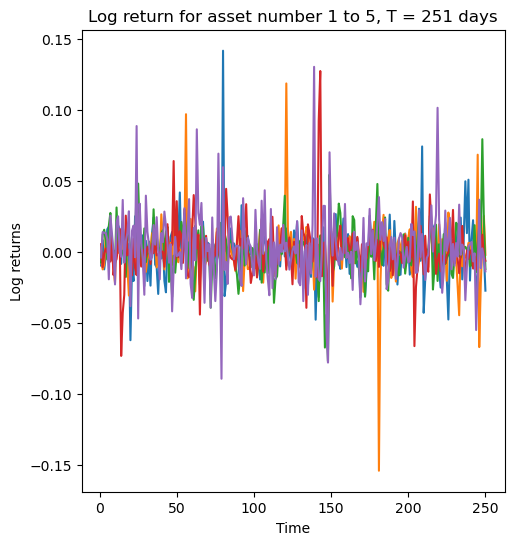

In [1689]:
# You are given a prices array of shape (N, T), where N = number of stocks and T = number of days.
# Return a (N, T-1) array of daily log returns.
def daily_log_returns(timeseries):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    daily_return = np.zeros((N, T-1))
    for day in range(1, T):
        daily_return[:, day - 1] = np.log(timeseries[:, day] / timeseries[:, day-1])
    return daily_return

# Backtesting: N = 5, T = 251 (over all execution date in 2024).
# We use the close to close return, only in this function.
N = 5
T = 251

returns = daily_log_returns(prices[0:N])

# Plot a graph for these returns:
time = np.linspace(1, T-1, T-1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(len(returns)):
    plt.plot(time, returns[i])
plt.title('Log return for asset number 1 to ' + str(N) + ', T = '+str(T) + ' days')
plt.xlabel('Time')
plt.ylabel('Log returns')

Text(0, 0.5, 'Sharpe ratio')

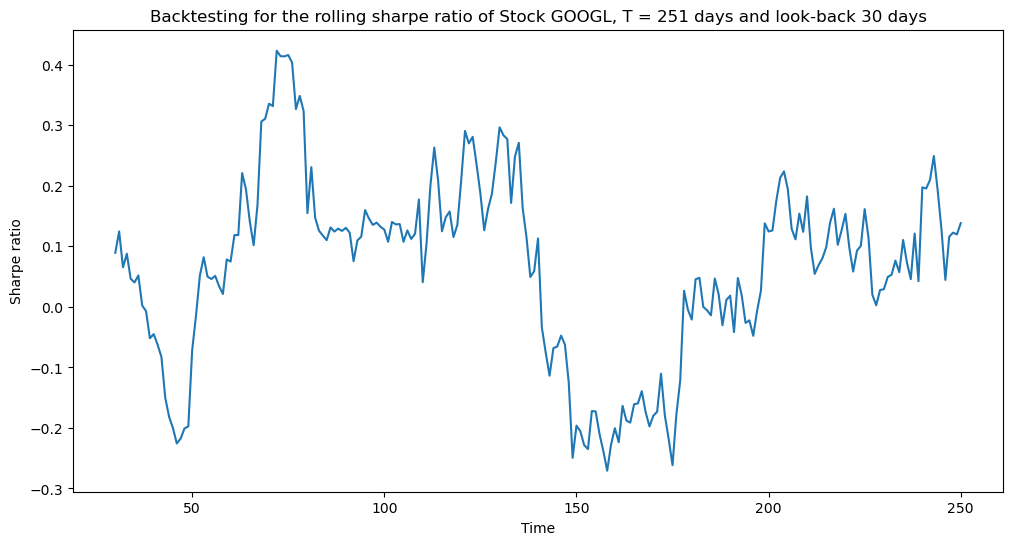

In [1690]:
# Compute the rolling Sharpe ratio of a given stock’s returns using a K=30 day window.
# Return a 1D array of Sharpe ratios aligned with days.
def rolling_Sharpe_ratio(timeseries, K = 30): # Here the time series is 1D.
    T = len(timeseries)
    if T <= K:
        raise Exception("Please enlarge K so that the pricing period covers the look-back period")
    Sharpe_ratio = ['NaN'] * K
    for day in range(K, T):
        log_return = daily_log_returns(np.array([timeseries[day - K: day]]))
        Sharpe_ratio.append(np.mean(log_return)/np.std(log_return, ddof = 1)) # In short period, assume risk-free rate is zero
    return Sharpe_ratio

# Backtesting over 'GOOGL' with K = 30, T = 251. Compute its rolling Sharpe ratio and plot from day 30.
stock_name = 'GOOGL'
stock_price = data_2024[data_2024['Ticker'] == stock_name].sort_values("Date").reset_index(drop=True)
sharpe_ratio = rolling_Sharpe_ratio(np.array(stock_price['Open'].tolist()), K = 30)
time = np.linspace(K, T-1, T-K)
plt.figure(figsize=(12, 6))
plt.plot(time, sharpe_ratio[K:])
plt.title('Backtesting for the rolling sharpe ratio of Stock ' + stock_name + ', T = '+str(T) + ' days and look-back ' + str(K) + " days")
plt.xlabel('Time')
plt.ylabel('Sharpe ratio')   

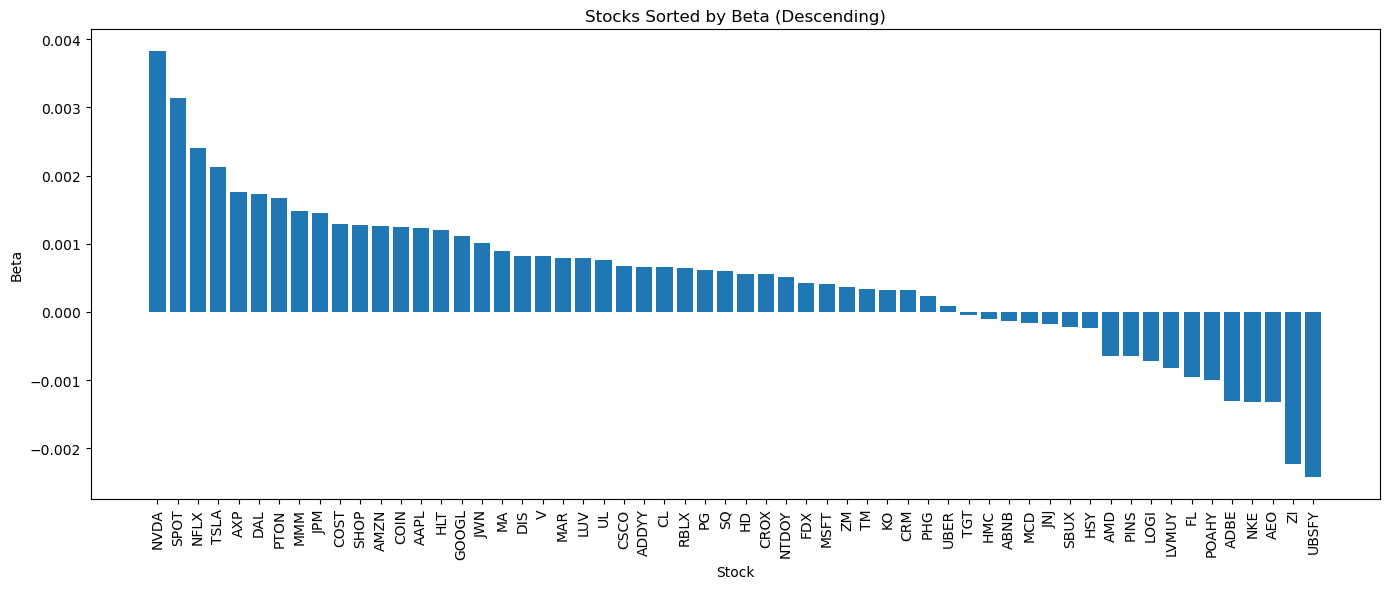

In [1691]:
# You are given synthetic stock returns plus a factor time series (e.g. market index).
# Estimate each stock’s beta via linear regression.
# Return a vector of betas.
def beta(stock_log_returns, market_returns = daily_log_returns(np.array([s_and_p_prices]))[0]):
    # In default case, we use the log returns of the S&P 500 ETF prices as the market index.
    b = []
    for stock in stock_log_returns:
        # Do the linear regression between the market index (S&P 500 ETF) and the stock prices.
        b.append(np.polyfit(market_returns, stock, 1)[1])
    return b

# Backtesting over all stocks (58) over the whole dataset. 
# Visualizing them as a histogram, sorting descending by Beta.

log_return = daily_log_returns(prices)
beta_stocks = beta(log_return)

stocks_beta = pd.DataFrame({"Stock": stock_types, "Beta": beta_stocks})
stocks_beta = stocks_beta.sort_values(by="Beta", ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(stocks_beta["Stock"], stocks_beta["Beta"])
plt.xticks(rotation=90)
plt.xlabel("Stock")
plt.ylabel("Beta")
plt.title("Stocks Sorted by Beta (Descending)")
plt.tight_layout()
plt.show()

In [1692]:
# Given daily returns (N, T), compute the correlation matrix between stocks.
# Cluster stocks into groups with average correlation ≥ 0.7.
# Return a list of clusters.
def cluster(timeseries, correlation_bound = 0.7):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    correlation_matrix = np.corrcoef(timeseries)
    
    # Convert the (historical) correlation matrix into distance matrix and extracts only its upper triangular part
    distance = 1-correlation_matrix
    condensed_dist = distance[np.triu_indices_from(distance, k=1)]
    
    # Perform agglomerative hierarchical clustering using average linkage, forming cluster.
    linkage_matrix = linkage(condensed_dist, method='average')
    clusters = fcluster(linkage_matrix, t= 1 - correlation_bound, criterion='distance')
    return clusters

# Backtesting over all dataset, cluster 56 stocks into groups with average correlation >= 0.7.
# Give the ticker name in each group.
cor_bound = 0.7
cluster_result = cluster(prices, cor_bound)
cluster_dic = {}
for j in range(1, max(cluster_result)+1):
    cluster_dic["Group " + str(j)] = []
for i in range(len(cluster_result)):
    cluster_dic["Group " + str(cluster_result[i])].append(stock_types[i])

# Sort groups by size
print("Group the stock with average correlation >= 0.7:")
sorted_groups = sorted(cluster_dic.items(), key=lambda x: len(x[1]), reverse=True)
for i in range(len(sorted_groups)):
    print("Group" + str(i+1) + " : " +str(sorted_groups[i][-1]))

# Forexample, in Group 5, GOOGL and MSFT are both big tech firms.

Group the stock with average correlation >= 0.7:
Group1 : ['V', 'CRM', 'MAR', 'HD', 'PTON', 'MA', 'RBLX', 'ZM', 'SHOP', 'TSLA', 'SQ', 'CSCO']
Group2 : ['SPOT', 'HLT', 'COST', 'NVDA', 'JPM', 'NFLX', 'JWN', 'AXP', 'DAL', 'AMZN', 'AAPL']
Group3 : ['MMM', 'CL', 'UL', 'PG', 'ADDYY', 'PHG', 'KO']
Group4 : ['TM', 'HMC', 'AEO', 'LVMUY', 'POAHY']
Group5 : ['GOOGL', 'MSFT']
Group6 : ['SBUX', 'MCD']
Group7 : ['UBSFY', 'PINS']
Group8 : ['ZI', 'NKE']
Group9 : ['FDX']
Group10 : ['COIN']
Group11 : ['LUV']
Group12 : ['NTDOY']
Group13 : ['ADBE']
Group14 : ['FL']
Group15 : ['JNJ']
Group16 : ['CROX']
Group17 : ['HSY']
Group18 : ['UBER']
Group19 : ['TGT']
Group20 : ['LOGI']
Group21 : ['ABNB']
Group22 : ['DIS']
Group23 : ['AMD']


Text(0, 0.5, 'Portfolio values')

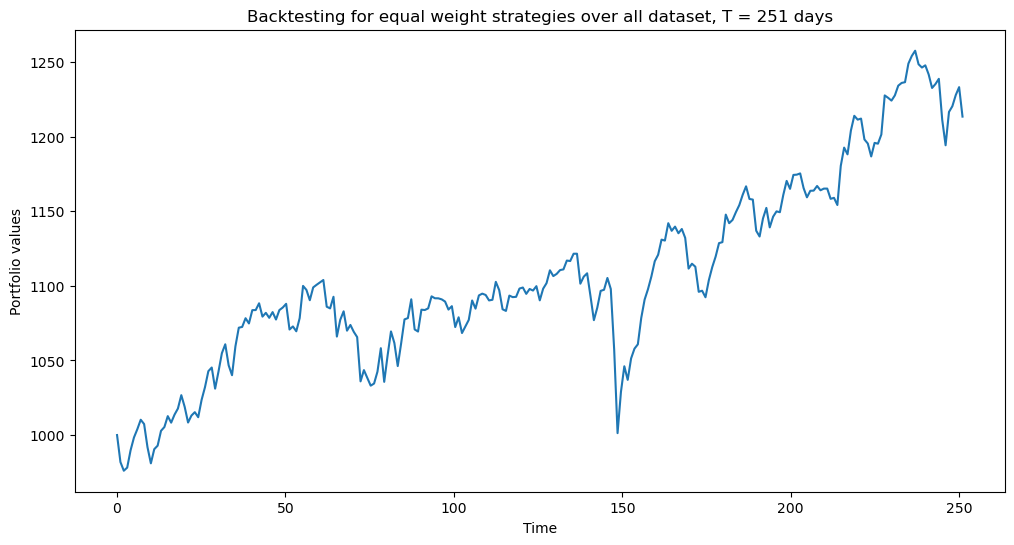

In [1693]:
# ---------------------We start to build different investment strategies.------------------------------------

# Given prices (N, T) and initial capital C, backtest a strategy where you always hold equal weights 
# in all assets, rebalancing daily.
# Return the portfolio values (into a list):

def equal_weight_strategies(timeseries, C):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    shares = (C/N) / timeseries[:, 0]
    port_value = [C]
    value = C
    for t in range(1, T):
        value  = timeseries[:, t] @ shares
        port_value.append(value) 
    # Rebalance, but always equal weight:
        shares = (value/N)/ timeseries[:, t]
    return port_value

# Backtesting with the whole dataset, T = 251, and C = 1,000
# Plot a graph for explaining the portfolio values changes
T = 251
starting_date = '01.02'

equal_weight = equal_weight_strategies(prices, 1000)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, equal_weight)
plt.title('Backtesting for equal weight strategies over all dataset' +  ', T = '+str(T) + ' days')
plt.xlabel('Time')
plt.ylabel('Portfolio values')

Text(0, 0.5, 'Portfolio values')

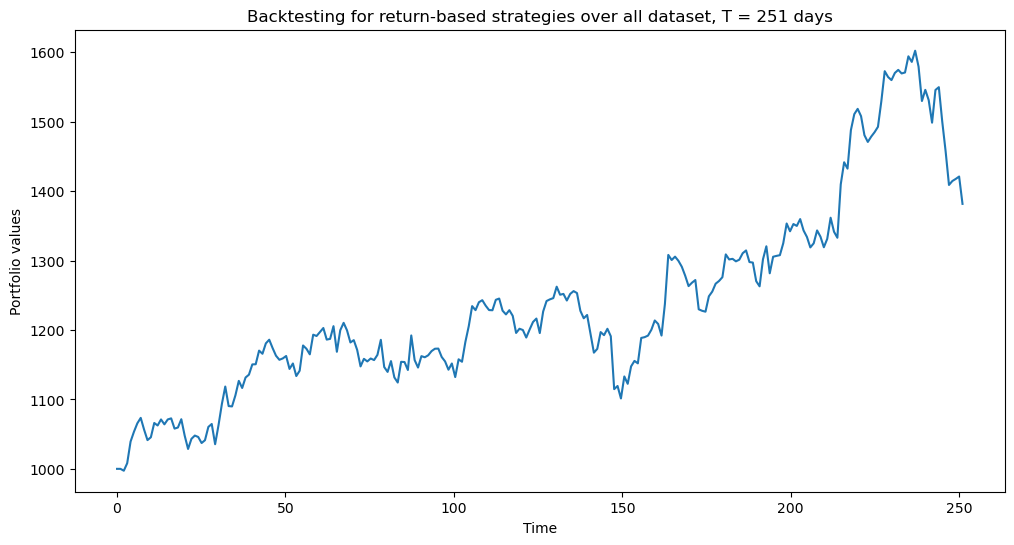

In [1694]:
# Momentum Allocation Strategies:
# Allocate to stocks proportionally to their last day’s return (skip negatives, keep in cash).
# Backtest over the whole dataset and return final value.
def return_strategies(timeseries, C):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    port_value = [C]
    value = C
    shares = np.array([0]*N)
    for t in range(1, T):
        if np.all(shares == 0):
            port_value.append(value)
        else:
            value = timeseries[:, t] @ shares
            port_value.append(value)
        
        # Rebalance
        ret = (timeseries[:, t] - timeseries[:, t-1])/timeseries[:, t-1]
        # We skip negatives
        ret[ret <0] = 0
        
        if np.all(ret == 0):
            shares = np.array([0]*N)
        else:
            weight = ret/np.sum(ret)
            shares = value * weight / timeseries[:, t]
    return port_value

# Backtesting over all dataset and plot, starting from 01.02 to the next 251 days.
C = 1000
return_strategy = return_strategies(prices, C)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, return_strategy)
plt.title('Backtesting for return-based strategies over all dataset' +  ', T = '+str(T) + ' days')
plt.xlabel('Time')
plt.ylabel('Portfolio values')       

Text(0, 0.5, 'Portfolio values')

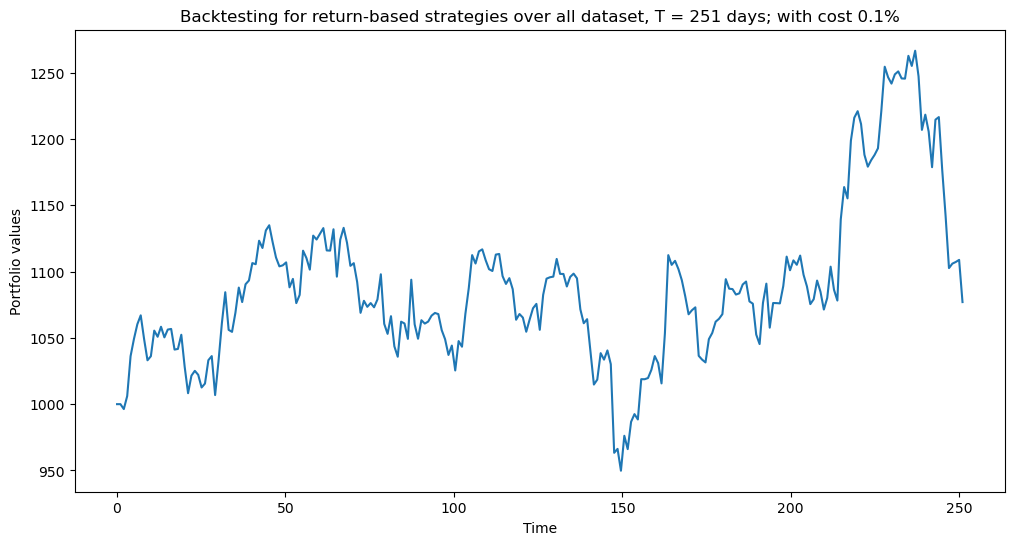

In [1695]:
# Repeat the momentum allocation strategy, but include a 0.1% transaction cost every time changing allocations.
# Return portfolio values.
def return_strategies_with_cost(timeseries, C, cost = 0.001):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    port_value = [C]
    value = C
    shares = np.array([0]*N)
    for t in range(1, T):
        if np.all(shares == 0):
            port_value.append(value)
        else:
            # Take the transaction cost into consideration, if the allocations are changed.
            value = timeseries[:, t] @ shares * (1-cost)
            port_value.append(value)
        
        # Rebalance
        ret = (timeseries[:, t] - timeseries[:, t-1])/timeseries[:, t-1]
        ret[ret <0] = 0
        if np.all(ret == 0):
            shares = np.array([0]*N)
        else:
            weight = ret/np.sum(ret)
            shares = value * weight / timeseries[:, t]
    return port_value

# Backtesting over all dataset and plot, starting from 01.02 to the next 251 days.
C = 1000
cost = 0.001
return_strategy_with_cost = return_strategies_with_cost(prices, C, cost)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, return_strategy_with_cost)
plt.title('Backtesting for return-based strategies over all dataset' +  ', T = '+str(T) + ' days; '+ "with cost " + str(cost*100) + "%")
plt.xlabel('Time')
plt.ylabel('Portfolio values')     

Text(0, 0.5, 'Portfolio values')

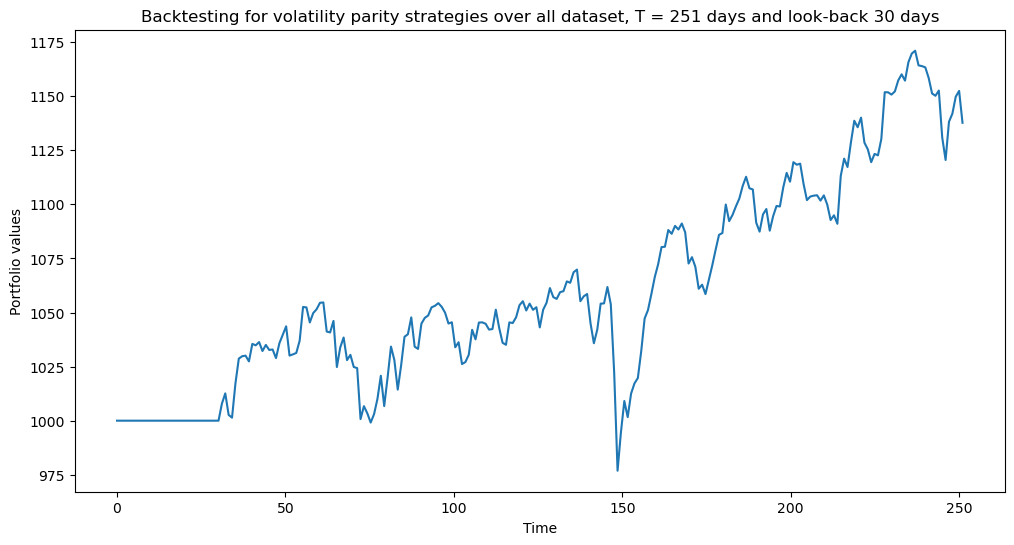

In [1696]:
# At each day t, compute each stock’s volatility over the last K=30 days.
# Allocate inversely to volatility (higher weight to low-vol stocks).
# Return daily portfolio values.
def vol_strategies(timeseries, C, K = 30):
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    # Exclude the case that the price period given cannot cover the lookback window.
    if T <= K:
        raise Exception("Please enlarge K so that the pricing period covers the look-back period")
    
    # Allow for the first K day to be uninvested, wait until the lookback window is gone.
    portfolio_value = [C]*K
    value = C
    weight = np.array(N*[0])
    shares = np.array(N*[0])
    for day in range(K,T):
        if np.all(shares == 0):
            portfolio_value.append(value)
        else:
            value = timeseries[:, day]@ shares
            portfolio_value.append(value)
            
    # Rebalance
        log_return_last_K = daily_log_returns(timeseries[:, (day-K): day])
        hist_vola = np.array([np.std(log_return_last_K[stock_num], ddof = 1) for stock_num in range(N)])
        # Use a small epsilon to avoid numerical issues.
        hist_vola = np.where(hist_vola == 0, 1e-8, hist_vola)
        # Compute weight, letting lower-volatility stocks to have higher weight
        weight = (1/hist_vola)/ np.sum((1/hist_vola))
        shares = value * weight/ timeseries[:, day]
    return portfolio_value

# Backtesting over all dataset and plot, starting from 01.02 to the next T = 251 days with look-back K = 30
K = 30
C = 1000
vol_strategy = vol_strategies(prices, C, K)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, vol_strategy)
plt.title('Backtesting for volatility parity strategies over all dataset' +  ', T = '+str(T) + ' days and look-back ' + str(K) + " days")
plt.xlabel('Time')
plt.ylabel('Portfolio values')       

Text(0, 0.5, 'Portfolio values')

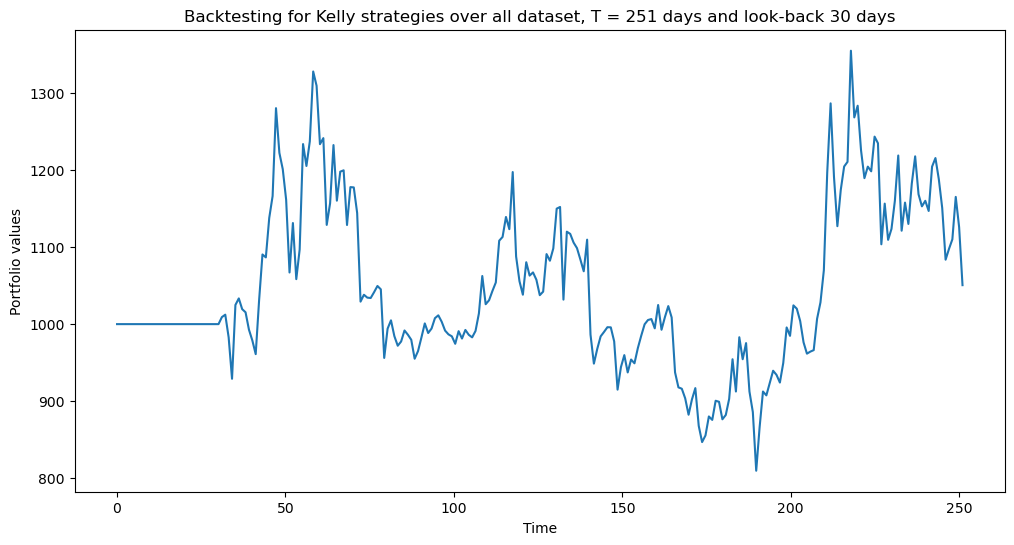

In [1697]:
# At each day, compute daily return distribution across stocks. Use Kelly formula to allocate weights.
# Use a rolling window of K = 30 days to estimate the covariance.
def Kelly_strategies(timeseries, C,  K = 30, positive_weight = True):
    # Here is an additional input of positive_weight. The reason is the following:
    # The Kelly optimal weights are determined by the maximization problem w^T \mu-0.5 w^T \Sigma w, under constraint sum(w) == 1.
    # Mathematically, they are equivalent to w_t = \Sigma_t^{-1} \mu_t with normalization where:
    # Sigma_t is the covariance function and \mu_t is the daily log return function at time point t.
    # For the case when positive_weight is set to be False, we use the second form, since it is numerically better.
    # If it is set to be True, then we use the first form (maximization problem), but with extra constraint of w>= 0
    # It turns out that imposing positive weights always performs better, since our rolling window 30 is not larger enough.
    # Therefore, the covariance matrix could not be accurate enough, and the portfolio value will have strong fluctuations.
    # Especially under the case that we allow for short positions.
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    if T <= K:
        raise Exception("Please enlarge K so that the pricing period covers the look-back period")
    portfolio_value = [C]*K
    value = C
    weight = np.array(N*[0])
    shares = np.array(N*[0])
    for day in range(K, T):
        if np.all(shares == 0):
            portfolio_value.append(value)
        else:
            value = timeseries[:, day]@ shares
            portfolio_value.append(value)
        
    # Rebalance:
        prices_last_K = timeseries[:, (day - K):day]
        daily_return_last_K = np.exp(daily_log_returns(prices_last_K))-1
        mu = np.mean(daily_return_last_K, axis = 1)
        sigma = np.cov(daily_return_last_K, ddof = 1)
        w = cp.Variable(N)
        objective = cp.Maximize(mu @ w - 0.5 * cp.quad_form(w, sigma))
    # Differ the case between whether imposing positive weights:    
        if positive_weight:
    # Use the maximization form:
            constraints = [cp.sum(w) == 1, w >= 0]
            prob = cp.Problem(objective, constraints)
            prob.solve()
            if prob.status not in ["optimal", "optimal_inaccurate"]:
                raise ValueError("No optimal solution found")
            weight = np.array(w.value).flatten()
    # Use the linear equation system form:
        else:
            weight = np.linalg.solve(sigma, mu)
            if not np.all(weight == 0):
                weight = weight/ np.sum(weight)
        
        shares = value * weight / timeseries[:, day]
    return portfolio_value
        
# Backtesting over all dataset and plot, starting from 01.02 to the next T = 251 days with look-back K = 30
K = 30
Kelly_strategy = Kelly_strategies(prices, 1000, K)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, Kelly_strategy)
plt.title('Backtesting for Kelly strategies over all dataset' +  ', T = '+str(T) + ' days and look-back ' + str(K) + " days")
plt.xlabel('Time')
plt.ylabel('Portfolio values')     

In [1698]:
# Given covariance matrix of stock returns, compute weights for the minimum variance portfolio.
# Return the weight vector.

# Similarly, for the minimum variance weight, one option is to minimize the variance w^T \Sigma w under constraint sum(w) = 1;
# Or, alternatively, we could use the explicit solution of \Sigma w = 1, where 1 is the one vector, and normalize them.
# If we impose the extra condition of long only, then we need to use the first definition by adding extra constraint of w>= 0.
def minimum_variance_weight(covariance):
    N, T = np.shape(covariance)
    if N != T:
        raise Exception("Input matrix is not a covariance matrix, please double check further.")
    one = np.ones(N)
    nominator = np.linalg.solve(covariance, one)
    return nominator/(one @ nominator)

def minimum_variance_weight_long_only(sigma):
    N = sigma.shape[0]
    w = cp.Variable(N)

    # Objective: minimize variance = w^T Σ w
    objective = cp.Minimize(cp.quad_form(w, sigma))

    # Constraints: weights sum to 1 and are non-negative
    constraints = [cp.sum(w) == 1, w >= 0]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("QP solver did not find a solution!")

    return np.array(w.value).flatten()

Sigma = np.array([
    [0.04,  0.006, 0.018],
    [0.006, 0.09,  0.012],
    [0.018, 0.012, 0.025]
])
print("Example Sigma:" + str(Sigma))
print("The minimum variance weight is " + str(minimum_variance_weight(Sigma)))
print("The minimum variance positive weight is " + str( minimum_variance_weight_long_only(Sigma)))
# Note that for this Sigma, the above two solution should coincide.

Example Sigma:[[0.04  0.006 0.018]
 [0.006 0.09  0.012]
 [0.018 0.012 0.025]]
The minimum variance weight is [0.23654284 0.14025777 0.62319939]
The minimum variance positive weight is [0.23654284 0.14025777 0.62319939]


Text(0, 0.5, 'Portfolio values')

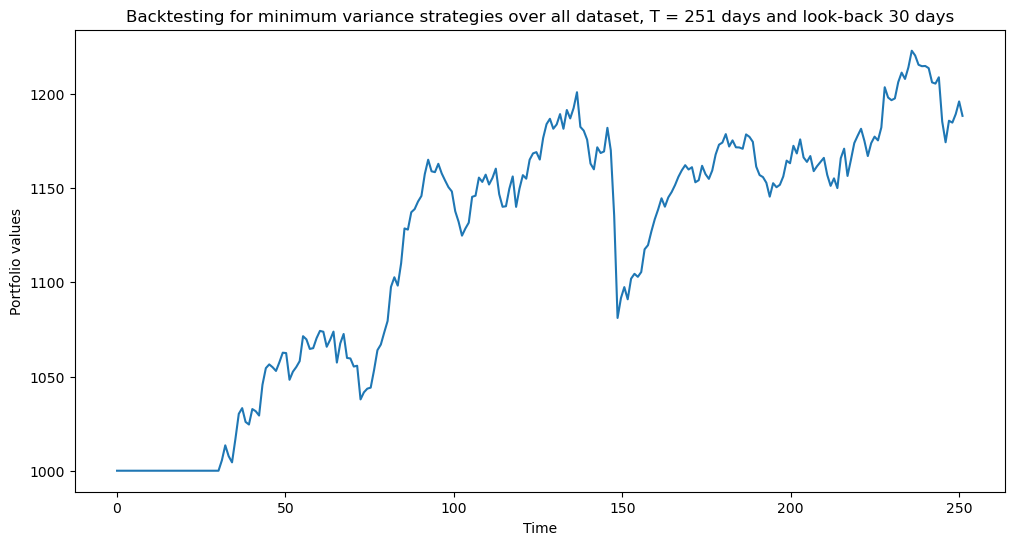

In [1699]:
# At each day, compute daily return distribution across stocks. Use minimum variance formula to allocate weights.
# Use a rolling window of K = 30 days to estimate the covariance.
def MV_strategies(timeseries, C,  K = 30, positive_weight = True):
    
    N = np.shape(timeseries)[0]
    T = np.shape(timeseries)[1]
    if T <= K:
        raise Exception("Please enlarge K so that the pricing period covers the look-back period")
    portfolio_value = [C]*K
    value = C
    weight = np.array(N*[0])
    shares = np.array(N*[0])
    for day in range(K, T):
        if np.all(shares == 0):
            portfolio_value.append(value)
        else:
            value = timeseries[:, day]@ shares
            portfolio_value.append(value)
        
    # Rebalance
        prices_last_K = timeseries[:, (day - K):day]
        daily_return_last_K = np.exp(daily_log_returns(prices_last_K))-1
        sigma = np.cov(daily_return_last_K,rowvar=True,  ddof = 1)
        if positive_weight: 
        # Similarly, under the case that positive_weight = True, we use the optimizing problem;
            weight = minimum_variance_weight_long_only(sigma)
        else:
        # under the case that positive_weight = False, we use the linear equation system for numerical reasons.
            weight = minimum_variance_weight(sigma)
        shares = value * weight / timeseries[:, day]
    return portfolio_value
        
# Backtesting over all dataset and plot, starting from 01.02 to the next T = 251 days with look-back K = 30
K = 30
MV_strategy = MV_strategies(prices, 1000, K)
time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))
plt.plot(time, MV_strategy)
plt.title('Backtesting for minimum variance strategies over all dataset' +  ', T = '+str(T) + ' days and look-back ' + str(K) + " days")
plt.xlabel('Time')
plt.ylabel('Portfolio values')     

In [1700]:
# Analyze the strategies by average sharpe ratio:
def annualized_sharpe_ratio(timeseries, risk_free_rate=0.0): # Here the timeseries should be an 1D array
    T = len(timeseries)

    simple_returns = np.exp(daily_log_returns(np.array([timeseries])))-1

    excess_returns = simple_returns - risk_free_rate / T
    
    mean_excess = np.mean(excess_returns)
    std_excess = np.std(excess_returns, ddof=1)
    
    sharpe = mean_excess / std_excess
    
    sharpe_annualized = sharpe * np.sqrt(T)
    return sharpe_annualized

# Compute all Sharpe ratios first and store them in a dictionary
sharpe_ratios = {
    "Equal weight strategy": annualized_sharpe_ratio(equal_weight),
    "Momentum Allocation strategy": annualized_sharpe_ratio(return_strategy),
    "Momentum Allocation strategy with cost level 0.1%": annualized_sharpe_ratio(return_strategy_with_cost),
    "Volatility parity strategy": annualized_sharpe_ratio(vol_strategy),
    "Kelly strategy (long-only)": annualized_sharpe_ratio(Kelly_strategy),
    "Minimum variance strategy (long-only)": annualized_sharpe_ratio(MV_strategy),
}

print("Average Sharpe ratio of the following strategies:")
for name, value in sharpe_ratios.items():
    print(f"-- {name}: {value:.4f}")

best_strategy = max(sharpe_ratios, key=sharpe_ratios.get)
worst_strategy = min(sharpe_ratios, key=sharpe_ratios.get)

print("Based on the Sharpe ratio, the best performed strategy is " + str(best_strategy)+ ".")
print("The worst performed strategy is " + str(worst_strategy) + ".")


Average Sharpe ratio of the following strategies:
-- Equal weight strategy: 1.3434
-- Momentum Allocation strategy: 1.4165
-- Momentum Allocation strategy with cost level 0.1%: 0.4214
-- Volatility parity strategy: 1.1437
-- Kelly strategy (long-only): 0.3832
-- Minimum variance strategy (long-only): 1.6135
Based on the Sharpe ratio, the best performed strategy is Minimum variance strategy (long-only).
The worst performed strategy is Kelly strategy (long-only).


In [1701]:
# Given daily portfolio returns, compute the historical VaR at confidence level α = 0.05.
# Return the 5% quantile of returns.
def historical_VaR(timeseries, alpha = 0.05): # Here the timeseries should be 1D
    return abs(np.quantile(timeseries, alpha, method = "higher")) # Using the higher nearst method, which is more conservative.


# Backtesting over all strategies that are implemented above, visualize there 5% historical VaR of the log_returns

equal_weight_VaR = historical_VaR(daily_log_returns(np.array([equal_weight])))
Momentum_Allocation_VaR = historical_VaR(daily_log_returns(np.array([return_strategy])))
Momentum_Allocation_cost_VaR = historical_VaR(daily_log_returns(np.array([return_strategy_with_cost])))
Vol_VaR = historical_VaR(daily_log_returns(np.array([vol_strategy])))
Positive_Kelly_VaR = historical_VaR(daily_log_returns(np.array([Kelly_strategy])))
Positive_MV_VaR = historical_VaR(daily_log_returns(np.array([MV_strategy])))

# Store all VaR values in a dictionary
var_results = {
    "Equal weight strategy": equal_weight_VaR,
    "Momentum Allocation strategy": Momentum_Allocation_VaR,
    "Momentum Allocation strategy with cost level 0.1%": Momentum_Allocation_cost_VaR,
    "Volatility parity strategy": Vol_VaR,
    "Kelly strategy (long-only)": Positive_Kelly_VaR,
    "Minimum variance strategy (long-only)": Positive_MV_VaR,
}

print("Historical VaR at the confidence level α = 0.05 of :")
for name, value in var_results.items():
    print(f"-- {name}: {value:.4f}")

# Lower (less negative) VaR is usually better (less risk)! 
best_strategy = min(var_results, key=var_results.get)   
worst_strategy = max(var_results, key=var_results.get)  

print("Based on the historical VaR, the best performed strategy is " + str(best_strategy)+ ".")
print("The worst performed strategy is " + str(worst_strategy) + ".")


Historical VaR at the confidence level α = 0.05 of :
-- Equal weight strategy: 0.0160
-- Momentum Allocation strategy: 0.0231
-- Momentum Allocation strategy with cost level 0.1%: 0.0241
-- Volatility parity strategy: 0.0129
-- Kelly strategy (long-only): 0.0666
-- Minimum variance strategy (long-only): 0.0102
Based on the historical VaR, the best performed strategy is Minimum variance strategy (long-only).
The worst performed strategy is Kelly strategy (long-only).


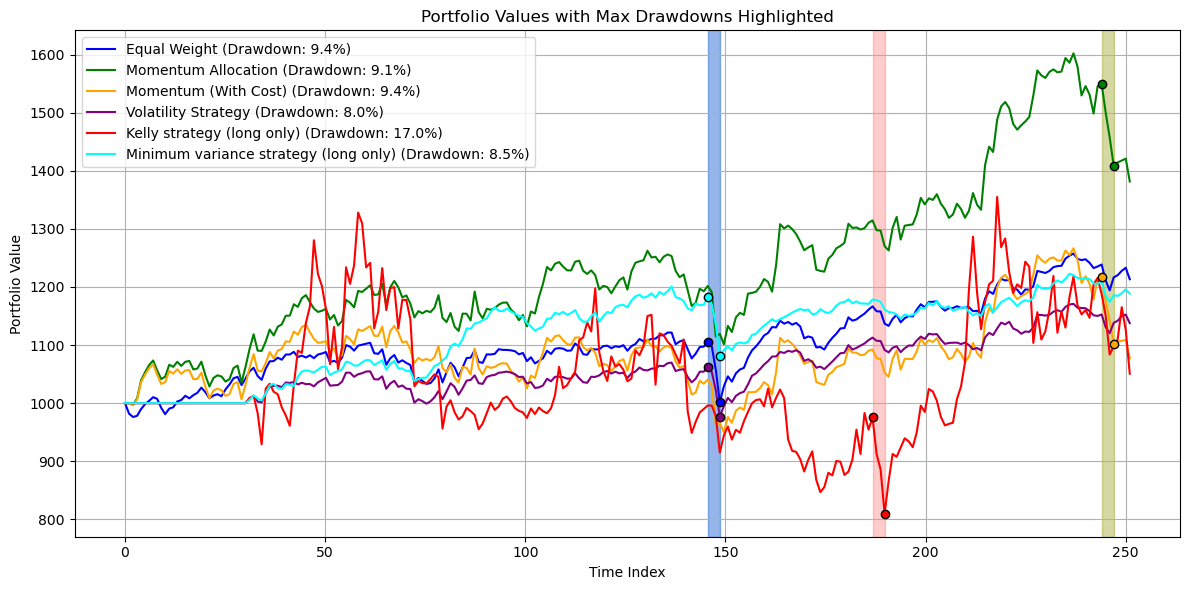

Based on the maximum drawdown, the best performed strategy is Volatility parity strategy.
The worst performed strategy is Kelly strategy (long-only).


In [1702]:
# Given a portfolio value time series, compute the maximum drawdown (largest peak-to-trough loss), in percentage.
# Return the drawdown percentage and the indices where it starts and ends.
def maximum_drawdown(timeseries): # Here the time series is 1D.
    drawdown = 0
    idx = []
    for i in range(len(timeseries)-1):
        j = 1
        while i + j < len(timeseries) and timeseries[i+j] <= timeseries[i+j-1]:
            j += 1
        down_rate = (timeseries[i] - timeseries[i+j-1])/timeseries[i]
        if down_rate > drawdown:
            idx = [i, i+j-1]
            drawdown = down_rate
    return [drawdown]+idx

# Backtesting on all strategies that are implemented above, visualize their maximum drawdown period.
equal_weight_drawdown = maximum_drawdown(equal_weight)
Momentum_Allocation_drawdown = maximum_drawdown(return_strategy)
Momentum_Allocation_cost_drawdown = maximum_drawdown(return_strategy_with_cost)
Vol_drawdown = maximum_drawdown(vol_strategy)
Kelly_drawdown = maximum_drawdown(Kelly_strategy)
MV_drawdown = maximum_drawdown(MV_strategy)

time = np.linspace(0, T, T)
plt.figure(figsize=(12, 6))

strategies = [
    ("Equal Weight", time, equal_weight, equal_weight_drawdown, "blue"),
    ("Momentum Allocation", time, return_strategy, Momentum_Allocation_drawdown, "green"),
    ("Momentum (With Cost)", time, return_strategy_with_cost, Momentum_Allocation_cost_drawdown, "orange"),
    ("Volatility Strategy", time, vol_strategy, Vol_drawdown, "purple"),
    ("Kelly strategy (long only)", time, Kelly_strategy, Kelly_drawdown, "red"),
    ("Minimum variance strategy (long only)", time, MV_strategy, MV_drawdown, "cyan")
]

for title, t, portfolio, dd, color in strategies:
    dd_rate, start_idx, end_idx = dd
    plt.plot(t, portfolio, label=f"{title} (Drawdown: {dd_rate*100:.1f}%)", color=color)
    
    # Highlight drawdown zone
    plt.axvspan(t[start_idx], t[end_idx], color=color, alpha=0.2)
    plt.scatter([t[start_idx], t[end_idx]],
                [portfolio[start_idx], portfolio[end_idx]],
                color=color, edgecolor="black", zorder=3)

plt.title("Portfolio Values with Max Drawdowns Highlighted")
plt.xlabel("Time Index")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

drawdowns = {
    "Equal weight strategy": equal_weight_drawdown[0],
    "Momentum Allocation strategy": Momentum_Allocation_drawdown[0],
    "Momentum Allocation strategy with cost level 0.1%": Momentum_Allocation_cost_drawdown[0],
    "Volatility parity strategy": Vol_drawdown[0],
    "Kelly strategy (long-only)": Kelly_drawdown[0],
    "Minimum variance strategy (long-only)": MV_drawdown[0],
}
# NOTE: Lower drawdown is better (less severe drop from peak).
best_strategy = min(drawdowns, key=drawdowns.get)   # min = smallest drawdown = best
worst_strategy = max(drawdowns, key=drawdowns.get)  # max = largest drawdown = worst

print("Based on the maximum drawdown, the best performed strategy is " + str(best_strategy)+ ".")
print("The worst performed strategy is " + str(worst_strategy) + ".")


In [1703]:
# A short summary on the ranking for the above three metrics
data = {
    "Equal weight strategy": {
        "Sharpe Ratio": annualized_sharpe_ratio(equal_weight),
        "0.05-VaR": equal_weight_VaR,
        "Max Drawdown": maximum_drawdown(equal_weight)[0]  # Use [0] as you noted
    },
    "Momentum Allocation strategy": {
        "Sharpe Ratio": annualized_sharpe_ratio(return_strategy),
        "0.05-VaR": Momentum_Allocation_VaR,
        "Max Drawdown": maximum_drawdown(return_strategy)[0]
    },
    "Momentum Allocation strategy (cost 0.1%)": {
        "Sharpe Ratio": annualized_sharpe_ratio(return_strategy_with_cost),
        "0.05-VaR": Momentum_Allocation_cost_VaR,
        "Max Drawdown": maximum_drawdown(return_strategy_with_cost)[0]
    },
    "Volatility parity strategy": {
        "Sharpe Ratio": annualized_sharpe_ratio(vol_strategy),
        "0.05-VaR": Vol_VaR,
        "Max Drawdown": maximum_drawdown(vol_strategy)[0]
    },
    "Kelly strategy (long-only)": {
        "Sharpe Ratio": annualized_sharpe_ratio(Kelly_strategy),
        "0.05-VaR": Positive_Kelly_VaR,
        "Max Drawdown": maximum_drawdown(Kelly_strategy)[0]
    },
    "Minimum variance strategy (long-only)": {
        "Sharpe Ratio": annualized_sharpe_ratio(MV_strategy),
        "0.05-VaR": Positive_MV_VaR,
        "Max Drawdown": maximum_drawdown(MV_strategy)[0]
    }
}

df = pd.DataFrame(data).T  

# For Sharpe: higher is better → descending rank
# For VaR: Lower (closer to 0) is better → ascending rank
# For Drawdown: lower is better → ascending rank
ranking_df = pd.DataFrame(index=df.index)
ranking_df["Sharpe Ratio rank"] = df["Sharpe Ratio"].rank(ascending=False).astype(int)
ranking_df["VaR (level = 0.05) rank"] = df["0.05-VaR"].rank(ascending=True).astype(int)
ranking_df["Max Drawdown rank"] = df["Max Drawdown"].rank(ascending=True).astype(int)

print("\n=== Strategy Ranking Table (1 = Best, 6 = Worst) ===")
print(ranking_df)



=== Strategy Ranking Table (1 = Best, 6 = Worst) ===
                                          Sharpe Ratio rank  \
Equal weight strategy                                     3   
Momentum Allocation strategy                              2   
Momentum Allocation strategy (cost 0.1%)                  5   
Volatility parity strategy                                4   
Kelly strategy (long-only)                                6   
Minimum variance strategy (long-only)                     1   

                                          VaR (level = 0.05) rank  \
Equal weight strategy                                           3   
Momentum Allocation strategy                                    4   
Momentum Allocation strategy (cost 0.1%)                        5   
Volatility parity strategy                                      2   
Kelly strategy (long-only)                                      6   
Minimum variance strategy (long-only)                           1   

                    